# ADA 2018 -  “Happiness” Share it through music.

#### Andres Montero, Ariel Alba, Diego Iriarte




In [1]:
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import reverse_geocoder as rg
import os.path
import seaborn as sns

from datetime import datetime, date, time
from scipy import stats

In [2]:
# Constants
DATA_DIR = './data/'
MUSIC_DIR = '{dir}{file}/'.format(dir=DATA_DIR, 
                                  file='fma_metadata')
PKL_DIR = '{dir}{file}/'.format(dir=DATA_DIR, 
                               file='pkl')
# True if we are going to read data from pickle files
READ_FROM_PKL = False
# True if we want to to execute the clean phase, with loading data from original source
CLEAN_PHASE = True


In [3]:
if CLEAN_PHASE:
    echonest_path = '{dir}{file}'.format(dir=MUSIC_DIR, 
                                         file='echonest.csv')
    features_path = '{dir}{file}'.format(dir=MUSIC_DIR,
                                         file='features.csv')
    genres_path = '{dir}{file}'.format(dir=MUSIC_DIR,
                                       file='genres.csv')
    tracks_path = '{dir}{file}'.format(dir=MUSIC_DIR,
                                       file='tracks.csv')
    

In [4]:
if CLEAN_PHASE:
    # Load datasets into pandas dataframes
    echonest_col_names=['track_id','danceability','energy',
                        'artist_latitude','artist_longitude',
                        'artist_name','artist_discovery',
                        'artist_family','artist_hotness',
                        'song_currency','song_hotness']
    echonest_dtypes = {'track_id': int, 'danceability': float, 
                       'energy': float, 'artist_latitude': float, 
                       'artist_longitude': float, 'artist_name': str,
                       'artist_discovery': float, 'artist_family': float,
                       'artist_hotness': float, 'song_currency': float,
                       'song_hotness': float}
    echonest_df = pd.read_csv(echonest_path, names=echonest_col_names,
                              header=3, dtype=echonest_dtypes, 
                              usecols=[0,2,3,11,13,14,21,22,23,24,25])

    genres_dtypes = {'genre_id': int, '#tracks': int, 
                     'parent': int, 'top_level': int}
    genres_df = pd.read_csv(genres_path, dtype=genres_dtypes)
    
    track_col_names = ['track_id', 'album_date_created',
                       'album_date_released', 'album_id',
                       'album_listens', 'album_title', 'artist_id',
                       'artist_name', 'track_duration', 'track_genre_top',
                       'track_language', 'track_listens', 'track_tags', 
                       'track_title']

    tracks_dtypes = {'track_id': int, 'album_date_created': str,
                     'album_date_released': str, 
                     'album_id': int, 'album_listens': int, 
                     'album_title': str, 'artist_id': int,
                     'artist_name': str, 'track_duration': int, 
                     'track_genre_top': str, 'track_language': str,
                     'track_listens': int, 'track_tags': str, 
                     'track_title': str}

    tracks_df = pd.read_csv(tracks_path, names=track_col_names,
                            header=2,
                            usecols=[0, 2, 3, 6, 8, 11, 21, 26, 38,
                                     40, 45, 47, 51, 52])


In [5]:
# Echonest clean phase 
if CLEAN_PHASE:
    # Get city, state, country from artist longitude and latitude
    cities=[]
    states=[]
    countries=[]
    
    for i in range (0, len(echonest_df)):
        if np.isnan(echonest_df.artist_latitude[i]):
            city = np.nan
            state = np.nan
            country = np.nan
        else:
            coordinates = (echonest_df.artist_latitude[i], 
                           echonest_df.artist_longitude[i])
            results = rg.search(coordinates, mode=1)
            city = results[0]['name']
            state = results[0]['admin1']
            country = results[0]['cc']
        
        cities.append(city)
        states.append(state)
        countries.append(country)
    
    echonest_df.insert(loc=5, column='city', 
                       value=pd.Series(cities))
    echonest_df.insert(loc=6, column='state',
                       value=pd.Series(states))
    echonest_df.insert(loc=7, column='country', 
                       value=pd.Series(countries))
    
    

Loading formatted geocoded file...


In [6]:
# Tracks clean phase
if CLEAN_PHASE:
    # Transforms str to datetime
    tracks_df['album_date_released'] = pd.to_datetime( \
                                            tracks_df['album_date_released'])
    tracks_df['album_date_created'] = pd.to_datetime( \
                                            tracks_df['album_date_created'])


In [7]:
if not READ_FROM_PKL:
    echonest_df.to_pickle('{dir}{file}'.format(dir=PKL_DIR, 
                                               file='echonest_df.pkl'))
    genres_df.to_pickle('{dir}{file}'.format(dir=PKL_DIR, 
                                             file='genres_df.pkl'))
    tracks_df.to_pickle('{dir}{file}'.format(dir=PKL_DIR, 
                                             file='tracks_df.pkl'))
else:
    echonest_df = pd.read_pickle('{dir}{file}'.format(dir=PKL_DIR, 
                                                      file='echonest_df.pkl'))
    genres_df = pd.read_pickle('{dir}{file}'.format(dir=PKL_DIR, 
                                                    file='genres_df.pkl'))
    tracks_df = pd.read_pickle('{dir}{file}'.format(dir=PKL_DIR, 
                                                    file='tracks_df.pkl'))
    

In [8]:
echonest_df.head()

,track_id,danceability,energy,artist_latitude,artist_longitude,city,state,country,artist_name,artist_discovery,artist_family,artist_hotness,song_currency,song_hotness
0,2,0.675894,0.634476,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
1,3,0.528643,0.817461,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
2,5,0.745566,0.701470,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
3,10,0.658179,0.924525,39.9523,-75.1624,Philadelphia,Pennsylvania,US,Kurt Vile,0.557339,0.614272,0.798387,0.005158,0.354516
4,134,0.513238,0.560410,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000


In [9]:
genres_df.head()


,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5


In [10]:
tracks_df


,track_id,album_date_created,album_date_released,album_id,album_listens,album_title,artist_id,artist_name,track_duration,track_genre_top,track_language,track_listens,track_tags,track_title
0,2,2008-11-26 01:44:45,2009-01-05,1,6073,AWOL - A Way Of Life,1,AWOL,168,Hip-Hop,en,1293,[],Food
1,3,2008-11-26 01:44:45,2009-01-05,1,6073,AWOL - A Way Of Life,1,AWOL,237,Hip-Hop,en,514,[],Electric Ave
2,5,2008-11-26 01:44:45,2009-01-05,1,6073,AWOL - A Way Of Life,1,AWOL,206,Hip-Hop,en,1151,[],This World
3,10,2008-11-26 01:45:08,2008-02-06,6,47632,Constant Hitmaker,6,Kurt Vile,161,Pop,en,50135,[],Freeway
4,20,2008-11-26 01:45:05,2009-01-06,4,2710,Niris,4,Nicky Cook,311,NaN,en,361,[],Spiritual Level
5,26,2008-11-26 01:45:05,2009-01-06,4,2710,Niris,4,Nicky Cook,181,NaN,en,193,[],Where is your Love?
6,30,2008-11-26 01:45:05,2009-01-06,4,2710,Niris,4,Nicky Cook,174,NaN,en,612,[],Too Happy
7,46,2008-11-26 01:45:05,2009-01-06,4,2710,Niris,4,Nicky Cook,104,NaN,en,171,[],Yosemite
8,48,2008-11-26 01:45:05,2009-01-06,4,2710,Niris,4,Nicky Cook,205,NaN,en,173,[],Light of Light
9,134,2008-11-26 01:44:45,2009-01-05,1,6073,AWOL - A Way Of Life,1,AWOL,207,Hip-Hop,en,943,[],Street Music


#### First we will see the top 10 countries were the music is produced.

In [11]:
#Merge data to have the entire data frame
tracks_echonest = pd.merge(echonest_df, tracks_df, left_on='track_id', right_on='track_id', how='right')
tracks_echonest.head()

,track_id,danceability,energy,artist_latitude,artist_longitude,city,state,country,artist_name_x,artist_discovery,...,album_listens,album_title,artist_id,artist_name_y,track_duration,track_genre_top,track_language,track_listens,track_tags,track_title
0,2,0.675894,0.634476,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,6073,AWOL - A Way Of Life,1,AWOL,168,Hip-Hop,en,1293,[],Food
1,3,0.528643,0.817461,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,6073,AWOL - A Way Of Life,1,AWOL,237,Hip-Hop,en,514,[],Electric Ave
2,5,0.745566,0.701470,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,6073,AWOL - A Way Of Life,1,AWOL,206,Hip-Hop,en,1151,[],This World
3,10,0.658179,0.924525,39.9523,-75.1624,Philadelphia,Pennsylvania,US,Kurt Vile,0.557339,...,47632,Constant Hitmaker,6,Kurt Vile,161,Pop,en,50135,[],Freeway
4,134,0.513238,0.560410,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,6073,AWOL - A Way Of Life,1,AWOL,207,Hip-Hop,en,943,[],Street Music


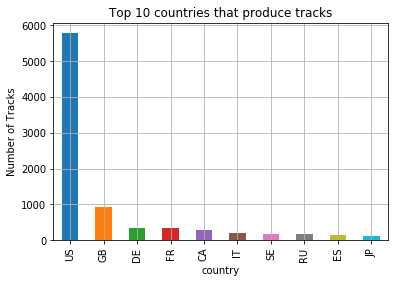

In [12]:
tracks_grouped = tracks_echonest.groupby(tracks_echonest['country']).size()
tracks_country_top10 = tracks_grouped.sort_values(ascending=False).head(10)
tracks_country_top10.plot(kind='bar', title="Top 10 countries that produce tracks")
plt.ylabel('Number of Tracks')
plt.grid()

#### Top 10 albums

In [13]:
def clean_neg(quantity):
    """Function to clean negative albums

    Args:
        quantity:  quantity.
    Returns:
        new_quantity: Cleaned quantity.
    """
    
    if quantity <= 0:
        new_quantity = 0
    else:
        new_quantity = quantity

    # Round quantity to not have float quantities
    return np.rint(new_quantity)

In [14]:
tracks_echonest['album_listens'] = tracks_echonest['album_listens'].apply(lambda x : clean_neg(x))
# tacks_echonest['album_listens']

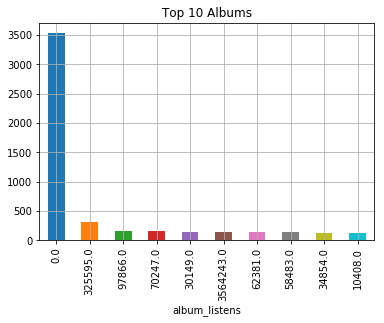

In [15]:
albums = tracks_echonest.groupby(tracks_echonest['album_listens']).size()
albums_top10 = albums.sort_values(ascending=False).head(10)
albums_top10.plot(kind='bar', title="Top 10 Albums")
plt.grid()



#### Top 10 Tracks

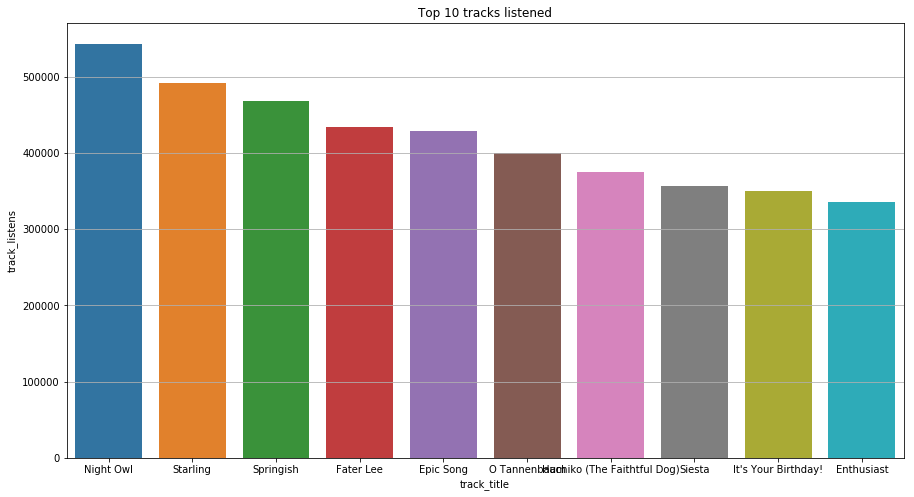

In [16]:
tracks_top10 = tracks_echonest.sort_values(by='track_listens', ascending=False).head(10)
plt.figure(figsize=(15,8))
plt.title("Top 10 tracks listened")
plt.grid()
ax = sns.barplot(x='track_title', y= 'track_listens', data=tracks_top10)


#### Relation between danceability and duration of the song

In [17]:
def cat_duration(quantity):
    """Function to clean inventory from raw data

    Args:
        quantity: Raw quantity.
    Returns:
        new_quantity: Official quantity.
    """
    
    if quantity <=2.0:
        return (1.0)
    elif quantity >2.0 & quantity<=4.0:
        return (2.0)
    else:
        return (3.0)


In [18]:
tracks_echonest.insert(loc=23,column='track_duration_minutes', value=(tracks_echonest['track_duration'] /60))

C:\Users\Andres Montero\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


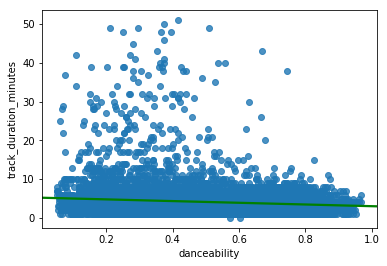

In [19]:
pd.to_numeric(tracks_echonest['track_duration_minutes'])
tracks_echonest['track_duration_minutes'] = tracks_echonest['track_duration_minutes'].apply(lambda x : np.rint(x))
sns.regplot(x='danceability', y='track_duration_minutes', data=tracks_echonest, ci=95, line_kws = {'color': 'green'})


In [20]:
tracks_echonest.head()

,track_id,danceability,energy,artist_latitude,artist_longitude,city,state,country,artist_name_x,artist_discovery,...,album_title,artist_id,artist_name_y,track_duration,track_genre_top,track_duration_minutes,track_language,track_listens,track_tags,track_title
0,2,0.675894,0.634476,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,AWOL - A Way Of Life,1,AWOL,168,Hip-Hop,3.0,en,1293,[],Food
1,3,0.528643,0.817461,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,AWOL - A Way Of Life,1,AWOL,237,Hip-Hop,4.0,en,514,[],Electric Ave
2,5,0.745566,0.701470,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,AWOL - A Way Of Life,1,AWOL,206,Hip-Hop,3.0,en,1151,[],This World
3,10,0.658179,0.924525,39.9523,-75.1624,Philadelphia,Pennsylvania,US,Kurt Vile,0.557339,...,Constant Hitmaker,6,Kurt Vile,161,Pop,3.0,en,50135,[],Freeway
4,134,0.513238,0.560410,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,AWOL - A Way Of Life,1,AWOL,207,Hip-Hop,3.0,en,943,[],Street Music


In [21]:
spearman_coeff = stats.spearmanr(tracks_echonest['danceability'], tracks_echonest['track_duration_minutes'])
spearman_coeff

SpearmanrResult(correlation=nan, pvalue=nan)

In [22]:
genre_year = tracks_echonest[['track_genre_top', 'album_date_released']]
genre_year.insert(loc=2,column='album_released_year', value=(genre_year['album_date_released'].dt.year))
genre_year.head()

,track_genre_top,album_date_released,album_released_year
0,Hip-Hop,2009-01-05,2009.0
1,Hip-Hop,2009-01-05,2009.0
2,Hip-Hop,2009-01-05,2009.0
3,Pop,2008-02-06,2008.0
4,Hip-Hop,2009-01-05,2009.0


In [23]:
top_genre = genre_year.groupby(genre_year['track_genre_top']).size()

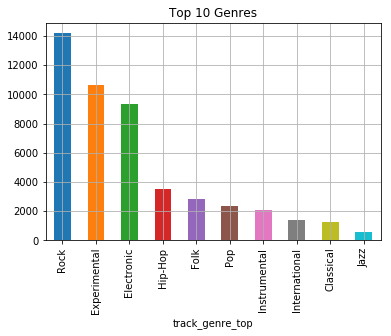

In [24]:
top_genre_sorted = top_genre.sort_values(ascending=False).head(10)
top_genre_sorted.plot(kind='bar', title="Top 10 Genres")
plt.grid()
